### Chapter 7.6 
# Overload Control Model
---
>(c) Tobias Hossfeld  (Aug 2021)<br><br>
> This script and the figures are part of the following book. The book is to be cited whenever the script is used (copyright CC BY-SA 4.0):<br>
> *Tran-Gia, P. & Hossfeld, T. (2021). 
Performance Modeling and Analysis of Communication Networks - A Lecture Note.
Würzburg University Press.*
> *https://doi.org/10.25972/WUP-978-3-95826-153-2*

---

The basic model of the overload control strategy considered in this chapter is of type (discrete-time) GI/GI/1 with a feedback-controlled input process. The analysis is done with an discrete-time algorithm and provides a generally applicable exact calculation algorithm. The algorithm provided to calculate system characteristics (e.g. customer blocking probability) is developed to estimate the performance of the overload control strategy. The results obtained show system behavior under stationary and non-stationary traffic conditions.

The following symbols and random variables are used:
* [$A_n$] r.v. for the interarrival time between the $n$-th and the $(n+1)$-st customer.
* [$B_n$] r.v. for the service time of the $n$-th customer.
* [$U_n$] r.v. for the amount of unfinished work (workload) which remains in the system (e.g., the number of tasks to be executed, not the number of customers) immediately prior to the arrival instant of the $n$-th customer. This measure is used as overload indicator.
* [$L$] threshold value of the overload control mechanism.

The main mechanism of the overload control strategy discussed is based on the following workload-driven customer acceptance scheme:
* [$U_n<L$]  the arriving customer will be accepted 
* [$U_n \geq L$] the arriving customer will be rejected


Chapter 7.6 derives a recursive relation to compute the workload at arrival times of customers.

$ \displaystyle
		u_{n+1}(k) = \pi_0\left[\sigma^{L}[u_n(k)]*b_n(k)*a_n(-k) \right] + \pi_0\left[\sigma_{L}[u_n(k)]*a_n(-k) \right]  \\
		= \pi_0\left[\left(\sigma^{L}[u_n(k)]*b_n(k) +\sigma_{L}[u_n(k)] \right) *a_n(-k) \right] 
$

In terms of random variables, we express this as follows.

$ \displaystyle
	 U_{n+1} =
	\begin{cases}
		\max(U_{n,0}+B_n-A_n,0) & \text{with probability} \; P(U_n<L) \\
		\max(U_{n,1}-A_n,0) & \text{with probability} \; P(U_n\geq L)
	\end{cases}
$


## Overload Situations
First, consider a sudden increase of the load at $n_1=40$ which decreases over time until $n_2=75$ (labeled 'peak'). This may be caused by some external events like flash-crowd events. Second, consider a constant overload situation between $n_1=40$ and $n_2=75$ (labeled 'constant'). The third overload situation is a triangular load curve. In all three overload situations, the average load $\bar{\rho}$ is chosen to be the same -- which is $\bar{\rho}=\sum_{n={n_1}}^{n_2} \rho_n =1.569$ in this numerical example. Before ($n<n_1$) and after ($n\geq n_2$) the overload situation, the regular load is $\rho^*=0.75$. 

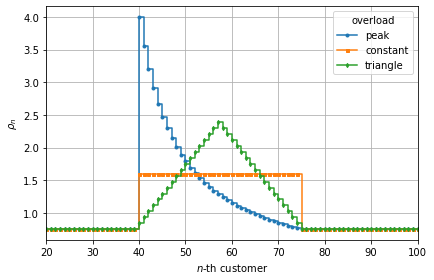

In [34]:
from matplotlib import pyplot as plt
import numpy as np
from discreteTimeAnalysis import *

# We define here the overload situations
def getRhoi(model=0, EB=10, rho0=0.75, rho1=4.0, j=40, k=75, xmax=150):
    x = np.arange(xmax)
    rhoi = np.zeros_like(x, dtype='float')+rho0
    Ai = np.zeros_like(x, dtype='float')
    Ak = EB/(rho1) # rho=EB/EA
    Aj = EB/rho0 # rho=EB/EA
    if model==0: # exponential decay        
        i = np.arange(j,k+1)        
        Ai[i] = (i-j)/(k-j)*(Aj-Ak)+Ak
        rhoi[i] = EB/Ai[i]
    elif model==1: # square        
        i = np.arange(j,k)
        tmp =  (i-j)/(k-j)*(Aj-Ak)+Ak
        rhoquer = (EB/tmp).sum()/(k-j)
        rhoi[i] = rhoquer
    elif model==2:
        if (k-j) % 2 == 0: 
            raise ValueError(f'range [{j} ; {k}] has no defined integer center')
        i = np.arange(j,k)
        tmp =  (i-j)/(k-j)*(Aj-Ak)+Ak
        rhosum = (EB/tmp).sum()
        m = int(j + (k-j)/2)
        i = np.arange(j,m)
        rhom = (rhosum+np.sum(2*rho0*(i-j+1)/(m-j+1)) - 2*(m-j)*rho0) / (1+np.sum(2*(i-j+1)/(m-j+1)))
        aha = (i-j+1)/(m-j+1)*(rhom-rho0)+rho0
        rhoi[i] = aha
        rhoi[m] = rhom
        i = np.arange(m+1,k)
        rhoi[i] = aha[::-1]
    else:
        raise ValueError(f'model {model} undefined')
    return rhoi, x


#%% plot the overload scenario
labels = ['peak', 'constant', 'triangle']
marks = ['o-','s-','d-']
msize= 3
xlim = [20, 100]

B = NEGBIN(5.0, 1.0)                    

xmax = 150
rhoi = np.zeros((xmax,3))

for i in range(3):
    rhoi[:,i], x = getRhoi(model=i, EB=B.mean(), rho0=0.75, rho1=4.0, j=40, k=75, xmax=xmax)
    plt.step(x,rhoi[:,i], marks[i], label=labels[i], where='post', markersize=msize)
plt.xlabel('$n$-th customer')
plt.ylabel('$\\rho_n$')
plt.tight_layout()
plt.grid(which='major')
plt.xlim(xlim)
plt.legend(title='overload');

## Implementation of Nonstationary Analysis
The recursive relation is now implemented with the module `DiscreteTimeAnalysis`. The unfinished work for an arriving customer represents the waiting time. 

$ \displaystyle
		u_{n+1}(k) = \pi_0\left[\sigma^{L}[u_n(k)]*b_n(k)*a_n(-k) \right] + \pi_0\left[\sigma_{L}[u_n(k)]*a_n(-k) \right]  \\
		= \pi_0\left[\left(\sigma^{L}[u_n(k)]*b_n(k) +\sigma_{L}[u_n(k)] \right) *a_n(-k) \right] 
$



In [28]:
def getOverloadControl_changingA(EA, EB=5, cB=1.0, L=5, steps=100, cA=1.0, epsMean = 1e-6, epsProb=1e-6):
    W = [DET(0)]        
    A0 = NEGBIN(EA[0],cA, eps=epsProb)
    B = NEGBIN(EB,cB, eps=epsProb)
    for i in np.arange(steps):
        if i<len(EA):
            A = NEGBIN(EA[i],cA, eps=epsProb)                    
        else:
            A = A0
        
        Wn = W[-1]
        part1 = pi0(Wn.sigmaTakeLT(L, normalized=False)+B-A) 
        part2 = pi0(Wn.sigmaTakeGEQ(L, normalized=False)-A)
        
        Wn1 = MIX((part1,  part2), (1,1))
        Wn1.name = None
        Wn1.trimCDF(eps=1e-64)        
        
        W.append( Wn1 )    
    
    return W

Play with the treshold parameter $L$ to see its impact on the results!

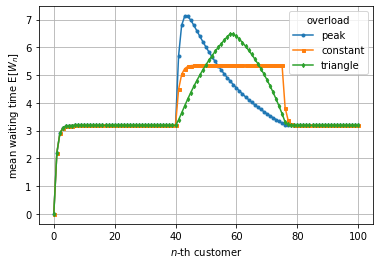

In [32]:
L = 5
#L = 500

EB = B.mean()
Wmeans = []
pBs = []
for i in range(3):
    EA = EB/rhoi[:,i]
    W = getOverloadControl_changingA(EA, EB=EB, L=L)
    m = np.array([Wi.mean() for Wi in W])
    Wmeans.append(m)    


for i in range(3):
    plt.plot(Wmeans[i],marks[i], label=labels[i], markersize=msize)
plt.xlabel('$n$-th customer')
plt.ylabel('mean waiting time E[$W_n$]')
plt.grid(which='major')
plt.legend(title='overload');